In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [2]:
def clean_process():
  df = pd.read_csv('/content/HistoricalPrices.csv')
  df['Date'] = pd.to_datetime(df['Date'])
  df = df[::-1].reset_index(drop=True)
  df["Tomorrow"] = df["Close"].shift(-1)
  df["Target"] = (df["Tomorrow"]>df['Close']).astype(int)
  df=df.dropna()
  df_outliers = remove_outliers_zscore(df,columns=['High','Low','Close','Open','Tomorrow'])
  return df

def remove_outliers_zscore(data, columns, threshold=2):
    data_no_outliers = data.copy()

    for column in columns:
        z_scores = np.abs((data[column] - data[column].mean()) / data[column].std())
        data_no_outliers = data_no_outliers[z_scores <= threshold]

    return data_no_outliers

# Random Forest Classifier

In [5]:
df = clean_process()
print(df.shape)
train_df = df[:-1800]
test_df = df[-1800:]
train_df

(9507, 7)


<ipython-input-2-ebc6f78f3872>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_no_outliers = data_no_outliers[z_scores <= threshold]


,Date,Open,High,Low,Close,Tomorrow,Target
0,1986-01-01,527.36,527.36,527.36,527.36,549.43,1
1,1986-01-02,549.43,549.43,549.43,549.43,561.01,1
2,1986-01-03,561.01,561.01,561.01,561.01,561.01,0
3,1986-01-06,561.01,561.01,561.01,561.01,564.35,1
4,1986-01-07,564.35,564.35,564.35,564.35,570.53,1
...,...,...,...,...,...,...,...
7702,2016-06-29,26627.15,26776.17,26606.31,26740.39,26999.72,1
7703,2016-06-30,26926.17,27069.23,26872.59,26999.72,27144.91,1
7704,2016-07-01,27064.33,27243.36,27061.40,27144.91,27278.76,1
7705,2016-07-04,27314.44,27385.66,27251.06,27278.76,27166.87,0


In [9]:
def featureExtraction(df):
  df["candleBody"] = abs(df["Open"] - df["Close"])
  df["candleSize"] = abs(df["High"]-df["Low"])
  df['gapUp'] = (df['Open'] > df['Close'].shift())
  df['gapUp'] = df['gapUp'].astype(int)
  df['gapDown'] = (df['Open'] < df['Close'].shift())
  df['gapDown'] = df['gapDown'].astype(int)
  df['red'] = 0
  df['green'] = 0
  df.loc[df['Close'] < df['Open'], 'red'] = 1
  df.loc[df['Close'] >= df['Open'], 'green'] = 1
  return df

In [10]:
df = featureExtraction(df)
df

,Date,Open,High,Low,Close,Tomorrow,Target,candleBody,candleSize,gapUp,gapDown,red,green
0,1986-01-01,527.36,527.36,527.36,527.36,549.43,1,0.00,0.00,0,0,0,1
1,1986-01-02,549.43,549.43,549.43,549.43,561.01,1,0.00,0.00,1,0,0,1
2,1986-01-03,561.01,561.01,561.01,561.01,561.01,0,0.00,0.00,1,0,0,1
3,1986-01-06,561.01,561.01,561.01,561.01,564.35,1,0.00,0.00,0,0,0,1
4,1986-01-07,564.35,564.35,564.35,564.35,570.53,1,0.00,0.00,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9502,2023-10-06,65867.54,66095.81,65762.33,65995.63,65512.39,0,128.09,333.48,1,0,0,1
9503,2023-10-09,65560.07,65789.98,65434.61,65512.39,66079.36,1,47.68,355.37,0,1,1,0
9504,2023-10-10,65662.27,66180.17,65662.27,66079.36,66473.05,1,417.09,517.90,1,0,0,1
9505,2023-10-11,66376.42,66592.16,66299.79,66473.05,66408.39,0,96.63,292.37,1,0,0,1


In [15]:
df = df.drop("Date",axis=1)

In [16]:
print(df)

          Open      High       Low     Close  Tomorrow  Target  candleBody  \
0       527.36    527.36    527.36    527.36    549.43       1        0.00   
1       549.43    549.43    549.43    549.43    561.01       1        0.00   
2       561.01    561.01    561.01    561.01    561.01       0        0.00   
3       561.01    561.01    561.01    561.01    564.35       1        0.00   
4       564.35    564.35    564.35    564.35    570.53       1        0.00   
...        ...       ...       ...       ...       ...     ...         ...   
9502  65867.54  66095.81  65762.33  65995.63  65512.39       0      128.09   
9503  65560.07  65789.98  65434.61  65512.39  66079.36       1       47.68   
9504  65662.27  66180.17  65662.27  66079.36  66473.05       1      417.09   
9505  66376.42  66592.16  66299.79  66473.05  66408.39       0       96.63   
9506  66564.57  66577.60  66339.42  66408.39  66282.74       0      156.18   

      candleSize  gapUp  gapDown  red  green  
0           0.00

In [17]:
from sklearn.ensemble import RandomForestClassifier
train = df[:-1800]
test = df[-1800:]
X_train = train.drop(["Tomorrow","Target"],axis=1)
y_train = train['Target']
X_test = test.drop(["Tomorrow","Target"],axis=1)
y_test = test['Target']
model = RandomForestClassifier()
model.fit(X_train,y_train)

RandomForestClassifier()

In [19]:
from sklearn.metrics import precision_score

preds = model.predict(X_test)

In [20]:
preds

array([0, 1, 0, ..., 0, 0, 1])

In [21]:
preds = pd.Series(preds, index=test.index)

In [22]:
preds

7707    0
7708    1
7709    0
7710    0
7711    1
       ..
9502    0
9503    1
9504    0
9505    0
9506    1
Length: 1800, dtype: int64

In [23]:
precision_score(y_test,preds)

0.5341880341880342

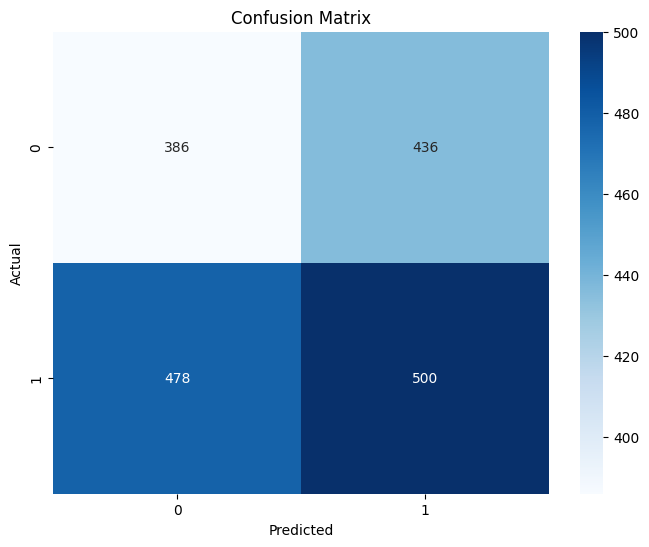

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Arima Model


In [ ]:
df = clean_process()
df = df[["Close"]].copy()

In [ ]:
df.describe()

,Close
count,8818.000000
mean,11535.788203
std,11687.248666
min,390.000000
25%,3062.727500
50%,4709.425000
75%,18619.507500
max,47746.220000


In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.Close.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"P-value: {result[1]}")

ADF Statistic: 1.4996079515566108
P-value: 0.9975228281242493


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

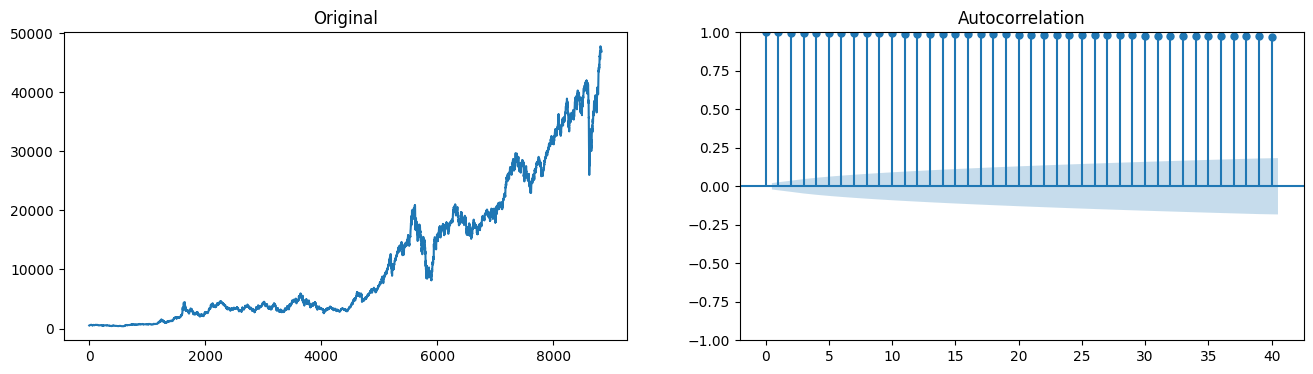

In [ ]:
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(16,4))
ax1.plot(df.Close)
ax1.set_title("Original")
plot_acf(df.Close,ax=ax2);

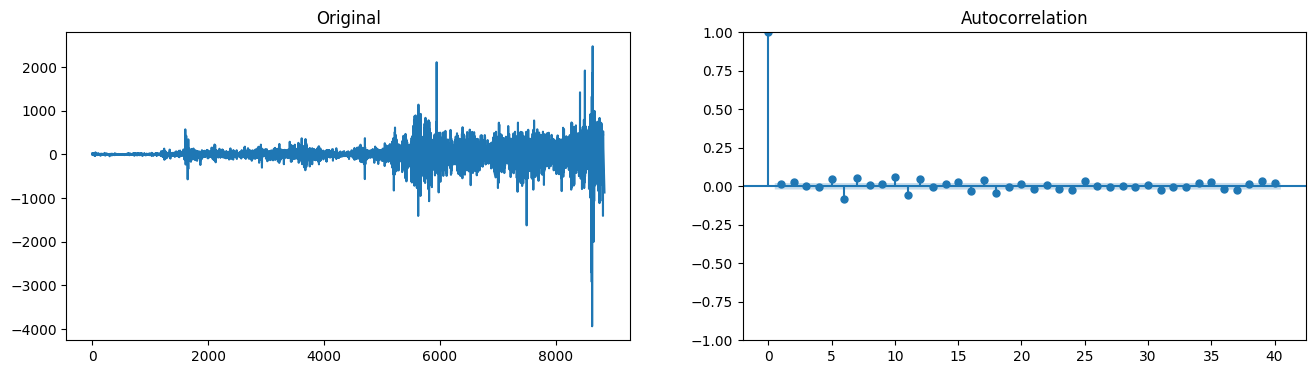

In [ ]:
diff = df.Close.diff().dropna()
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(16,4))
ax1.plot(diff)
ax1.set_title("Original")
plot_acf(diff,ax=ax2);

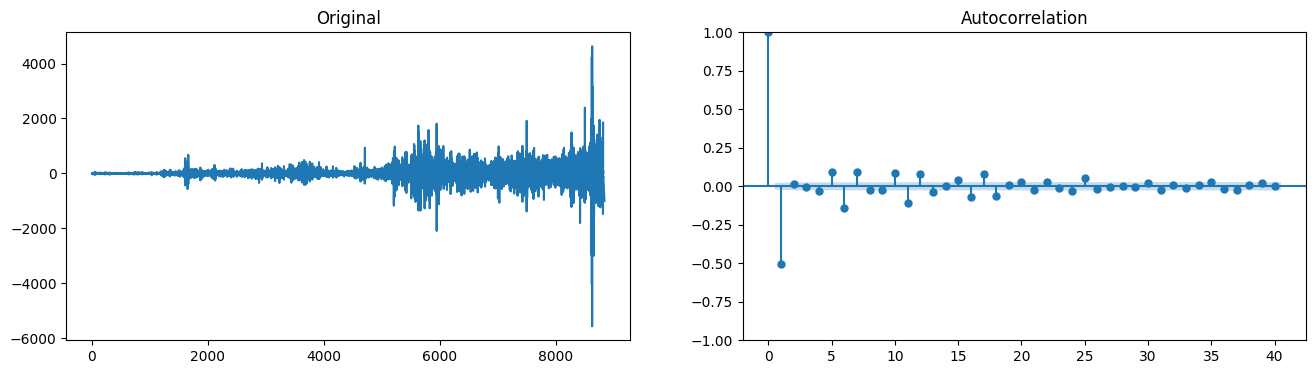

In [ ]:
diff = df.Close.diff().diff().dropna()
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(16,4))
ax1.plot(diff)
ax1.set_title("Original")
plot_acf(diff,ax=ax2);

In [ ]:
!pip install pmdarima
from pmdarima.arima.utils import ndiffs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.5 MB/s eta 0:00:00


In [ ]:
ndiffs(df.Close,test="adf")

1

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

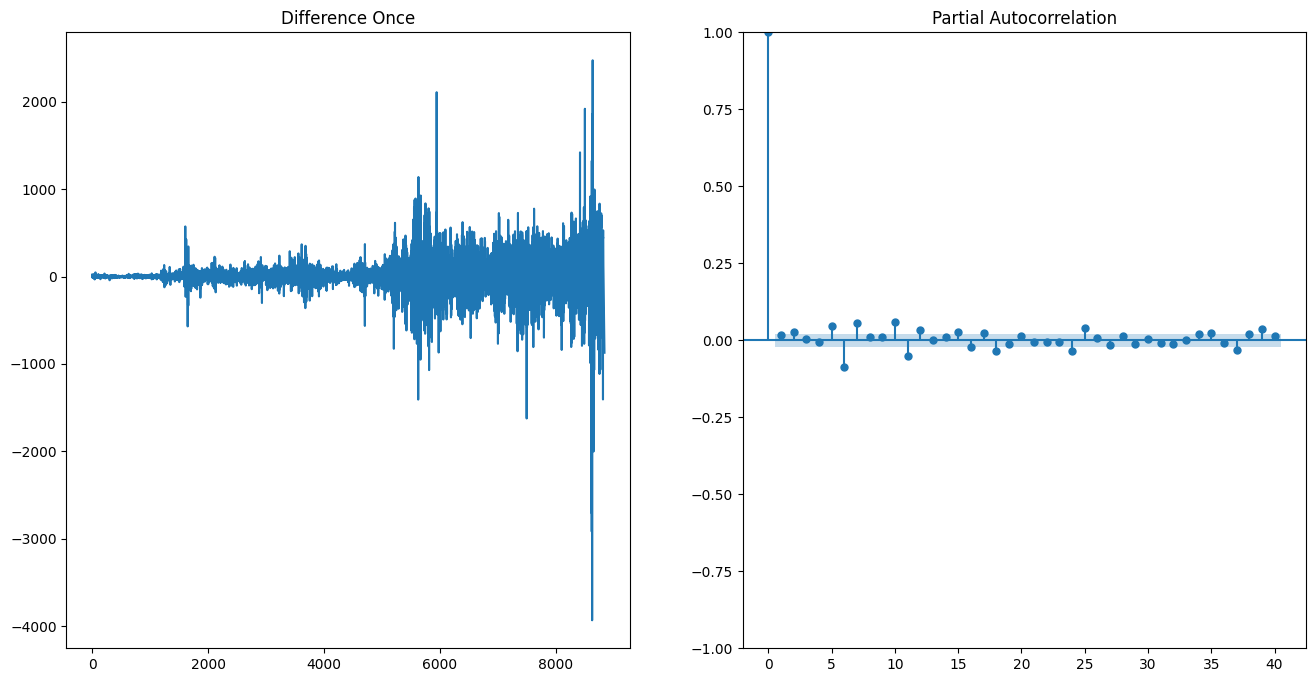

In [ ]:
diff = df.Close.diff().dropna()
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(16,8))
ax2.set_ylim(0,1)
ax1.plot(diff)
ax1.set_title("Difference Once")

plot_pacf(diff,ax=ax2);
plt.show()

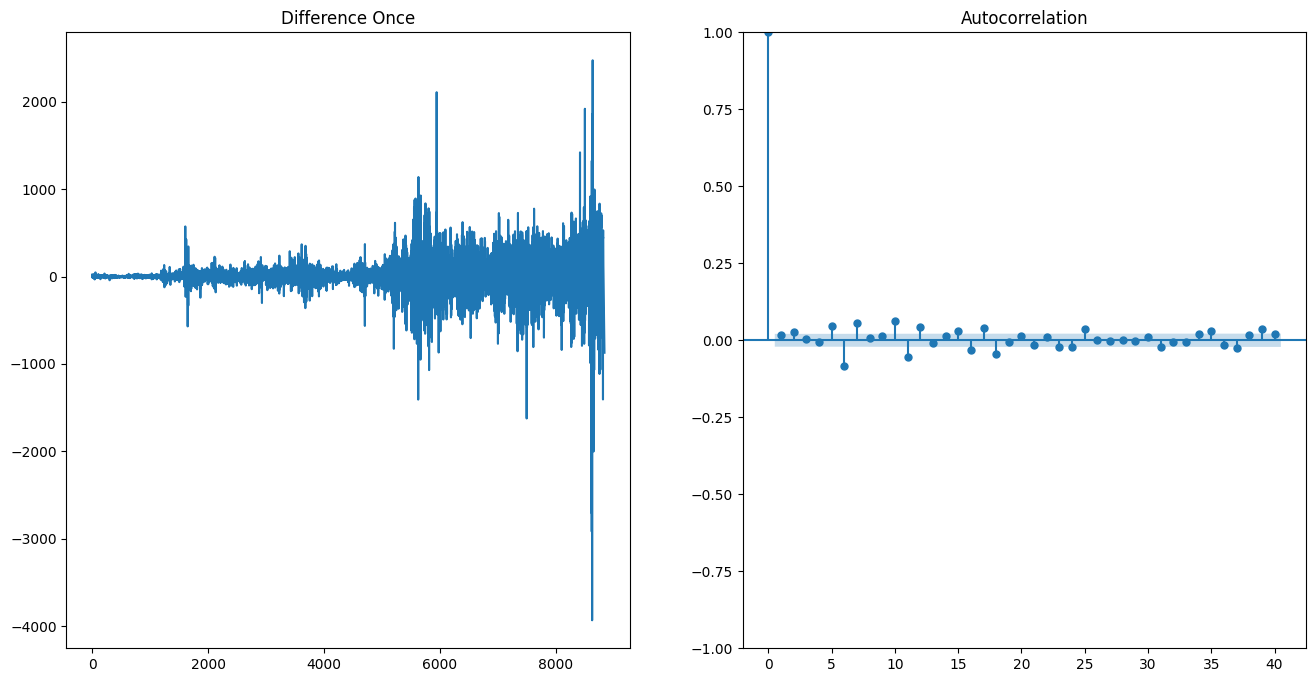

In [ ]:
diff = df.Close.diff().dropna()
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(16,8))
ax1.plot(diff)
ax1.set_title("Difference Once")
ax2.set_ylim(0,1)
plot_acf(diff,ax=ax2);

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
# Define the ARIMA model with the appropriate order (p, d, q)
model = ARIMA(df.Close, order=(5, 1, 2))
result = model.fit()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

In [ ]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 8818
Model:                 ARIMA(5, 1, 2)   Log Likelihood              -58978.900
Date:                Wed, 18 Oct 2023   AIC                         117973.800
Time:                        13:45:10   BIC                         118030.475
Sample:                             0   HQIC                        117993.105
                               - 8818                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3830      0.012   -110.928      0.000      -1.407      -1.359
ar.L2         -0.7508      0.012    -62.590      0.000      -0.774      -0.727
ar.L3          0.0554      0.007      7.625      0.0

(array([1.94065128e-07, 3.88130256e-07, 3.88130256e-07, 9.70325641e-07,
        1.26142333e-05, 4.95642337e-04, 1.18476761e-03, 1.45548846e-05,
        9.70325641e-07, 7.76260512e-07]),
 array([-3531.51321999, -2947.1506341 , -2362.78804822, -1778.42546234,
        -1194.06287645,  -609.70029057,   -25.33770469,   559.0248812 ,
         1143.38746708,  1727.75005296,  2312.11263885]),
 <BarContainer object of 10 artists>)

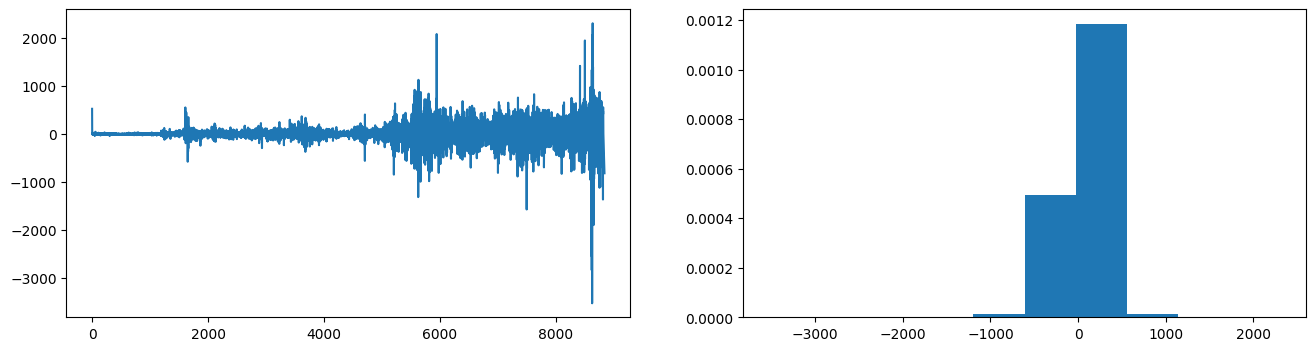

In [ ]:
residuals = pd.DataFrame(result.resid)
fig, (ax1,ax2)= plt.subplots(1,2,figsize=(16,4))

ax1.plot(residuals)
ax2.hist(residuals,density=True)


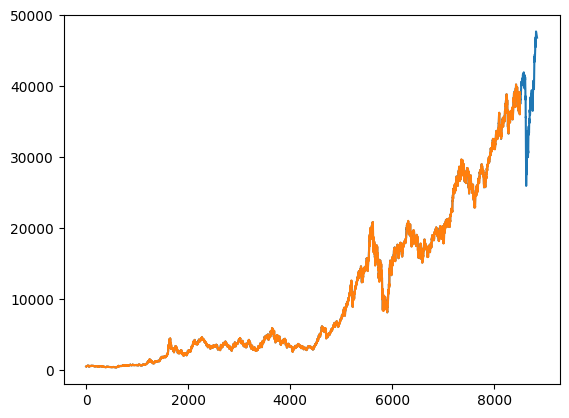

In [ ]:
plt.plot(df.Close)
plt.plot(pred.predicted_mean)
plt.show()

# Polynomial Regression


In [28]:
df

,Open,High,Low,Close,Tomorrow,Target,candleBody,candleSize,gapUp,gapDown,red,green
0,527.36,527.36,527.36,527.36,549.43,1,0.00,0.00,0,0,0,1
1,549.43,549.43,549.43,549.43,561.01,1,0.00,0.00,1,0,0,1
2,561.01,561.01,561.01,561.01,561.01,0,0.00,0.00,1,0,0,1
3,561.01,561.01,561.01,561.01,564.35,1,0.00,0.00,0,0,0,1
4,564.35,564.35,564.35,564.35,570.53,1,0.00,0.00,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9502,65867.54,66095.81,65762.33,65995.63,65512.39,0,128.09,333.48,1,0,0,1
9503,65560.07,65789.98,65434.61,65512.39,66079.36,1,47.68,355.37,0,1,1,0
9504,65662.27,66180.17,65662.27,66079.36,66473.05,1,417.09,517.90,1,0,0,1
9505,66376.42,66592.16,66299.79,66473.05,66408.39,0,96.63,292.37,1,0,0,1


In [41]:
X=df.drop(['Tomorrow','Target'],axis=1)
y=df['Tomorrow']

In [42]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=1)

In [43]:
scaler= StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

In [44]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression()

In [45]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3)
X_poly_train = poly.fit_transform(X_train_scaler)
X_poly_test = poly.transform(X_test_scaler)
poly.fit(X_poly_train,y_train)
lin.fit(X_poly_train,y_train)

LinearRegression()

In [46]:
y_pred = lin.predict(X_poly_test)

In [47]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test,y_pred)

268291.43120692583

In [48]:
y_pred_train = lin.predict(X_poly_train)
mean_absolute_error(y_train,y_pred_train)

123.79505142477285

In [49]:
from sklearn.metrics import r2_score
y_pred = lin.predict(X_poly_test)
r2 = r2_score(y_train, y_pred_train)
print("R^2 Score:", r2)


R^2 Score: 0.9998148009673071


###Neural Network


In [52]:
X=df.drop(['Tomorrow','Target'],axis=1)
y=df['Target']

In [53]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9507 entries, 0 to 9506
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        9507 non-null   float64
 1   High        9507 non-null   float64
 2   Low         9507 non-null   float64
 3   Close       9507 non-null   float64
 4   Tomorrow    9507 non-null   float64
 5   Target      9507 non-null   int64  
 6   candleBody  9507 non-null   float64
 7   candleSize  9507 non-null   float64
 8   gapUp       9507 non-null   int64  
 9   gapDown     9507 non-null   int64  
 10  red         9507 non-null   int64  
 11  green       9507 non-null   int64  
dtypes: float64(7), int64(5)
memory usage: 1.2 MB


In [50]:
import tensorflow as tf

0.1
223/223 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.5004
Train Loss: nan, Train Accuracy: 0.5004

75/75 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.5103
Test Loss: nan, Test Accuracy: 0.5103

0.01
223/223 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.5004
Train Loss: nan, Train Accuracy: 0.5004

75/75 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.5103
Test Loss: nan, Test Accuracy: 0.5103

0.001
223/223 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.5004
Train Loss: nan, Train Accuracy: 0.5004

75/75 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.5103
Test Loss: nan, Test Accuracy: 0.5103

0.0001
223/223 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.5004
Train Loss: nan, Train Accuracy: 0.5004

75/75 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.5103
Test Loss: nan, T

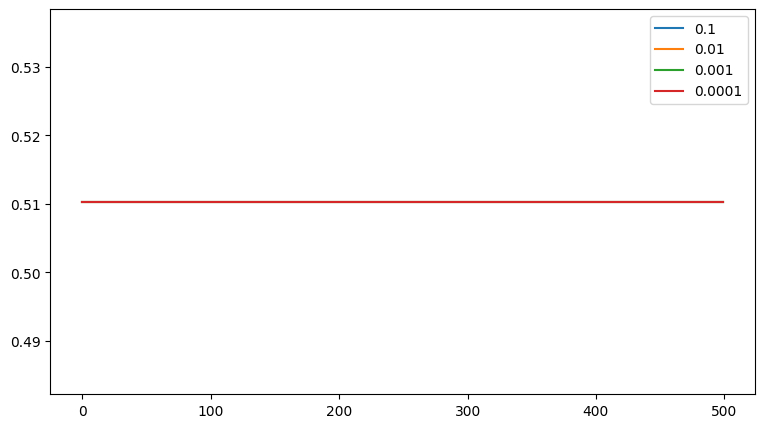

In [59]:
from keras.layers import Dense
from keras.layers import InputLayer
learning_rates = [0.1,0.01,0.001,0.0001]

plt.figure(figsize=(20,5))
for lr in learning_rates:
  model = tf.keras.Sequential()
  model.add(InputLayer(input_shape=(10,)))
  model.add(Dense(units=25,activation='relu', name='hidden_layer1'))
  model.add(Dense(units=50,activation='relu', name='hidden_layer2'))
  model.add(Dense(units=75,activation='relu', name='hidden_layer3'))
  model.add(Dense(units=1,activation='sigmoid', name='output_layer'))
  sgd = tf.keras.optimizers.SGD(learning_rate=lr)
  model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  history = model.fit(X_train,y_train,validation_data = (X_test,y_test), epochs = 500 , verbose=0)
  print(lr)
  loss, accuracy = model.evaluate(X_train, y_train)
  print(f'Train Loss: {loss:.4f}, Train Accuracy: {accuracy:.4f}\n')
  loss, accuracy = model.evaluate(X_test, y_test)
  print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}\n')
  plt.subplot(1,2,1)
  plt.plot(history.history['val_accuracy'], label = str(lr))
plt.legend()
plt.show()